# Spike Gadgets Ephys and Video Syncing

In [1]:
import os
import re
import sys
from collections import defaultdict
import random
from random import randrange
import glob
import warnings

In [2]:
import numpy as np
import pandas as pd
# import cv2
from IPython.display import Video
import matplotlib.pyplot as plt

In [3]:
# setting path
sys.path.append('../../../src')

In [4]:
%matplotlib inline

In [5]:
import spikeinterface

In [6]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/tmp/ipykernel_3247196/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [7]:
import spikeinterface.core

In [8]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [9]:
import spikeinterface.full as si

# Reading in the Timestamp Information

In [10]:
tone_label_file_ending = "tone_label_df"

In [11]:
tone_label_path = glob.glob("./proc/*{}.csv*".format(tone_label_file_ending))[0]

In [12]:
tone_label_path

'./proc/20221215_145401_comp_amd_om_6_1_top_4_base_3_tone_label_df.csv'

In [13]:
recording_name = os.path.splitext(os.path.basename(tone_label_path))[0].strip(tone_label_file_ending)

In [14]:
recording_name

'20221215_145401_comp_amd_om_6_1_top_4_base_3'

In [15]:
tone_time_stamps_df = pd.read_csv(tone_label_path, index_col=0)

In [16]:
tone_time_stamps_df

,tone_time_stamp,tone_category,tone_clock_time_comp,tone_clock_time_omission
0,1872697,win,60.01995,-1971.59705
1,3472694,win,140.01980,-1891.59720
2,5272689,win,230.01955,-1801.59745
3,6872686,win,310.01940,-1721.59760
4,8372686,win,385.01940,-1646.59760
5,10372684,win,485.01930,-1546.59770
6,12272681,win,580.01915,-1451.59785
7,14072678,win,670.01900,-1361.59800
8,15672676,win,750.01890,-1281.59810
9,17472673,win,840.01875,-1191.59825


# Reading in Phy

- Which unit the spike came from

In [17]:
spike_clusters_path = glob.glob("./proc/**/phy/spike_clusters.npy", recursive=True)[0]

In [18]:
spike_clusters_path[0]

'.'

In [19]:
spike_clusters = np.load(spike_clusters_path)

In [20]:
spike_clusters[:10]

array([ 56, 117,  70, 188,  14,  45, 113,  33,  33,  33], dtype=int32)

- The classification of each unit

In [21]:
cluster_info_path = glob.glob("./proc/**/phy/cluster_info.tsv", recursive=True)[0]

In [22]:
cluster_group_df = pd.read_csv(cluster_info_path, sep="\t")

In [23]:
cluster_group_df

,cluster_id,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
0,0,537.0,0,0.0,0.0,10.065295,mua,33564,0,1.0
1,1,335.0,0,0.0,0.0,0.261798,noise,873,0,2.0
2,2,196.0,1,0.0,20.0,1.181542,good,3940,0,3.0
3,3,200.0,1,0.0,20.0,0.937736,mua,3127,0,4.0
4,4,870.5,2,0.0,40.0,12.243950,good,40829,0,5.0
...,...,...,...,...,...,...,...,...,...,...
93,189,255.0,19,0.0,380.0,0.065675,noise,219,0,42.0
94,190,258.0,28,0.0,560.0,0.540690,good,1803,0,66.0
95,191,258.0,28,0.0,560.0,0.037785,noise,126,0,66.0
96,196,260.0,17,0.0,340.0,0.745211,mua,2485,0,39.0


- Filtering for the good units

In [24]:
good_unit_cluster_info_df = cluster_group_df[cluster_group_df["group"] == "good"]

In [25]:
good_unit_cluster_info_df

,cluster_id,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
2,2,196.0,1,0.0,20.0,1.181542,good,3940,0,3.0
4,4,870.5,2,0.0,40.0,12.243950,good,40829,0,5.0
17,18,1162.0,6,0.0,120.0,1.992727,good,6645,0,19.0
18,19,724.0,6,0.0,120.0,2.532517,good,8445,0,20.0
19,20,1159.0,7,0.0,140.0,9.170742,good,30581,0,21.0
22,25,888.0,9,0.0,180.0,16.430025,good,54788,0,26.0
34,45,890.0,21,0.0,420.0,0.612362,good,2042,0,46.0
37,48,1034.0,21,0.0,420.0,2.812009,good,9377,0,49.0
38,49,1610.5,21,0.0,420.0,1.599579,good,5334,0,50.0
40,52,225.0,23,0.0,460.0,1.151853,good,3841,0,53.0


In [26]:
good_unit_unique_ids = good_unit_cluster_info_df["cluster_id"].values

In [27]:
good_unit_unique_ids

array([  2,   4,  18,  19,  20,  25,  45,  48,  49,  52,  55,  58,  61,
        73, 113, 117, 122, 160, 164, 172, 178, 184, 190])

- The times that all the spikes happened

In [28]:
spike_time_path = glob.glob("./proc/**/phy/spike_times.npy", recursive=True)[0]

In [29]:
spike_times = np.load(spike_time_path)

In [30]:
spike_times[:10]

array([[  7],
       [ 58],
       [144],
       [212],
       [271],
       [322],
       [358],
       [393],
       [456],
       [511]])

- Getting a list of the IDs that were good from the list of unit ids for all the firings

In [31]:
good_unit_mask = np.isin(spike_clusters, good_unit_unique_ids)

In [32]:
good_unit_all_ids = spike_clusters[good_unit_mask]

In [33]:
good_unit_all_ids.shape

(263984,)

In [34]:
good_unit_all_ids[:10]

array([117,  45, 113,  58, 113, 172,  20, 113,  25,  52], dtype=int32)

- Getting the time that the good units fired

In [35]:
good_unit_times = spike_times[good_unit_mask].T[0]

In [36]:
good_unit_times.shape

(263984,)

In [37]:
good_unit_times[:10]

array([  58,  322,  358,  816,  896, 1093, 1288, 1383, 1505, 1546])

In [38]:
good_unit_times[-10:]

array([66690002, 66690291, 66690595, 66690718, 66690762, 66690844,
       66691239, 66691560, 66691843, 66692222])

- spike_times are indexed based on the start of the recording, not the start of the streaming
    - Last spike ends right before the end of the recording time

In [39]:
spike_times

array([[       7],
       [      58],
       [     144],
       ...,
       [66692377],
       [66692421],
       [66692459]])

In [40]:
spike_times[-1]/20000

array([3334.62295])

## Syncing the unit times with the ECU times

In [41]:
tone_time_stamps = tone_time_stamps_df["tone_time_stamp"].values

In [42]:
tone_time_stamps

array([ 1872697,  3472694,  5272689,  6872686,  8372686, 10372684,
       12272681, 14072678, 15672676, 17472673, 19472667, 21272667,
       23672664, 25472661, 27172659, 28972656, 30872654, 33272648,
       34872648, 42504638, 44104636, 45904633, 47504632, 49004630,
       51004627, 52904625, 54704622, 56304620, 58104616, 60104616,
       61904614, 64304611, 66104608])

## Seeing which tone time each unit time is closest to

- We will divide all the time up into bins of before and after each tone. Then we will see which time bin the neuron firing falls into.
    - So everything in the 0 bin would be before the first time bin. The 1 bin would be everything in between the first and second time bin. The last would be everything after last time bin.

In [43]:
good_unit_bins = np.digitize(good_unit_times, tone_time_stamps_df["tone_time_stamp"], right=True)

In [44]:
good_unit_bins.shape

(263984,)

In [45]:
good_unit_bins[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
good_unit_bins[-10:]

array([33, 33, 33, 33, 33, 33, 33, 33, 33, 33])

- Seeing if the firing time is within a 10 second interval before or 10 second after any tone

In [47]:
from collections import defaultdict

In [48]:
good_unit_bins.shape

(263984,)

In [49]:
good_unit_times.shape

(263984,)

In [50]:
good_unit_all_ids.shape

(263984,)

In [51]:
good_unit_times[:10]

array([  58,  322,  358,  816,  896, 1093, 1288, 1383, 1505, 1546])

In [52]:
tone_time_stamps

array([ 1872697,  3472694,  5272689,  6872686,  8372686, 10372684,
       12272681, 14072678, 15672676, 17472673, 19472667, 21272667,
       23672664, 25472661, 27172659, 28972656, 30872654, 33272648,
       34872648, 42504638, 44104636, 45904633, 47504632, 49004630,
       51004627, 52904625, 54704622, 56304620, 58104616, 60104616,
       61904614, 64304611, 66104608])

In [53]:
len(tone_time_stamps)

33

# Comparing Firing Rate between Trial types

In [54]:
tone_time_stamps_df.head()

,tone_time_stamp,tone_category,tone_clock_time_comp,tone_clock_time_omission
0,1872697,win,60.01995,-1971.59705
1,3472694,win,140.01980,-1891.59720
2,5272689,win,230.01955,-1801.59745
3,6872686,win,310.01940,-1721.59760
4,8372686,win,385.01940,-1646.59760


In [55]:
good_unit_times

array([      58,      322,      358, ..., 66691560, 66691843, 66692222])

In [56]:
good_unit_all_ids

array([117,  45, 113, ...,   4,   4,  61], dtype=int32)

In [57]:
good_unit_bins

array([ 0,  0,  0, ..., 33, 33, 33])

In [58]:
tone_time_stamps

array([ 1872697,  3472694,  5272689,  6872686,  8372686, 10372684,
       12272681, 14072678, 15672676, 17472673, 19472667, 21272667,
       23672664, 25472661, 27172659, 28972656, 30872654, 33272648,
       34872648, 42504638, 44104636, 45904633, 47504632, 49004630,
       51004627, 52904625, 54704622, 56304620, 58104616, 60104616,
       61904614, 64304611, 66104608])

In [59]:
"""
Step 1: 
- Get all the unit times that are 10 seconds before tone 
and 10 seconds after the tone(separately)

Step 2:
- Separate out for each trial

Step 3: Calculate firing rate
"""

'\nStep 1: \n- Get all the unit times that are 10 seconds before tone \nand 10 seconds after the tone(separately)\n\nStep 2:\n- Separate out for each trial\n\nStep 3: Calculate firing rate\n'

- Duration to include before and after tone

In [60]:
# time in seconds
trial_one_way_duration = 10

In [61]:
sampling_rate = 20000

- Getting the number of samples before and after to include for each tone

In [62]:
per_trial_number_of_samples = trial_one_way_duration * sampling_rate

In [63]:
per_trial_number_of_samples

200000

- Getting all the tones that fired within before or after the number of samples

In [64]:
before_or_after_column = "before_or_after"

In [65]:
# iterating through the timestamp of each good unit spike

before_and_after_interval_unit_times = defaultdict(dict)


for index, time in enumerate(good_unit_times):
    # getting the corresponding tone bin for the timestamp
    current_bin = good_unit_bins[index]
    current_neuron = good_unit_all_ids[index]   
#     print("Current Bin: {}".format(current_bin))
    
    # checking number before
    first_tone_time = tone_time_stamps[(current_bin - 1) % len(tone_time_stamps)]
    # checking number after
    second_tone_time = tone_time_stamps[(current_bin) % len(tone_time_stamps)]    
    
#     print("Time: {}, First tone time: {} Second tone time: {}".format(time, first_tone_time, second_tone_time))
    
    
    # checking if time is before first number
    if first_tone_time - per_trial_number_of_samples <= time <= first_tone_time:
        before_and_after_interval_unit_times[time]["tone_time"] = first_tone_time
        before_and_after_interval_unit_times[time][before_or_after_column] = "before"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    # checking if time is after first number
    elif first_tone_time < time <= first_tone_time + per_trial_number_of_samples:
        before_and_after_interval_unit_times[time]["tone_time"] = first_tone_time
        before_and_after_interval_unit_times[time][before_or_after_column] = "after"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    
    # checking if time is before second number
    elif second_tone_time - per_trial_number_of_samples <= time <= second_tone_time:
        before_and_after_interval_unit_times[time]["tone_time"] = second_tone_time
        before_and_after_interval_unit_times[time][before_or_after_column] = "before"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    # checking if time is after second number
    elif second_tone_time < time <= second_tone_time + per_trial_number_of_samples:
        before_and_after_interval_unit_times[time]["tone_time"] = second_tone_time
        before_and_after_interval_unit_times[time][before_or_after_column] = "after"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    else:
        continue


In [66]:
per_trial_number_of_samples

200000

In [67]:
before_and_after_interval_unit_df = pd.DataFrame.from_dict(before_and_after_interval_unit_times, orient="index").reset_index()
before_and_after_interval_unit_df = before_and_after_interval_unit_df.rename(columns={"index": "spike_time"})

In [68]:
before_and_after_interval_unit_df.head()

,spike_time,tone_time,before_or_after,neuron_id
0,1672940,1872697,before,113
1,1673010,1872697,before,4
2,1673176,1872697,before,61
3,1673338,1872697,before,73
4,1673406,1872697,before,25


- Getting the count of each neuron that fired during the tone interval grouped by the neuron's ID

In [69]:
before_and_after_tone_spike_count_df = before_and_after_interval_unit_df.groupby(["tone_time", before_or_after_column, "neuron_id"]).count().unstack(fill_value=0).stack().reset_index().rename(columns={"spike_time": "fired_spike_count"})

In [70]:
before_and_after_tone_spike_count_df

,tone_time,before_or_after,neuron_id,fired_spike_count
0,1872697,after,2,18
1,1872697,after,4,136
2,1872697,after,18,31
3,1872697,after,19,8
4,1872697,after,20,207
...,...,...,...,...
1513,66104608,before,164,6
1514,66104608,before,172,7
1515,66104608,before,178,5
1516,66104608,before,184,3


- Separating out the before and after to get them in the same rows for the same neuron

In [71]:
before_tone_spike_count_df = before_and_after_tone_spike_count_df[before_and_after_tone_spike_count_df[before_or_after_column] == "before"].rename(columns={"fired_spike_count": "before_fired_spike_count"}).drop(columns=[before_or_after_column])
after_tone_spike_count_df = before_and_after_tone_spike_count_df[before_and_after_tone_spike_count_df[before_or_after_column] == "after"].rename(columns={"fired_spike_count": "after_fired_spike_count"}).drop(columns=[before_or_after_column])

In [72]:
before_tone_spike_count_df.head()

,tone_time,neuron_id,before_fired_spike_count
23,1872697,2,13
24,1872697,4,192
25,1872697,18,18
26,1872697,19,8
27,1872697,20,76


In [73]:
after_tone_spike_count_df.head()

,tone_time,neuron_id,after_fired_spike_count
0,1872697,2,18
1,1872697,4,136
2,1872697,18,31
3,1872697,19,8
4,1872697,20,207


In [74]:
merged_before_after_tone_spike_count_df = pd.merge(left=before_tone_spike_count_df, right=after_tone_spike_count_df, left_on=["tone_time", "neuron_id"], right_on=["tone_time", "neuron_id"])

- Dictionary of tone time to trial type

In [75]:
tone_timestamp_to_trial_type = pd.Series(tone_time_stamps_df["tone_category"].values, index=tone_time_stamps_df["tone_time_stamp"]).to_dict()

In [76]:
tone_timestamp_to_trial_type

{1872697: 'win',
 3472694: 'win',
 5272689: 'win',
 6872686: 'win',
 8372686: 'win',
 10372684: 'win',
 12272681: 'win',
 14072678: 'win',
 15672676: 'win',
 17472673: 'win',
 19472667: 'win',
 21272667: 'win',
 23672664: 'win',
 25472661: 'win',
 27172659: 'win',
 28972656: 'win',
 30872654: 'win',
 33272648: 'win',
 34872648: 'loss',
 42504638: 'rewarded',
 44104636: 'rewarded',
 45904633: 'rewarded',
 47504632: 'omission',
 49004630: 'rewarded',
 51004627: 'rewarded',
 52904625: 'rewarded',
 54704622: 'rewarded',
 56304620: 'omission',
 58104616: 'rewarded',
 60104616: 'rewarded',
 61904614: 'omission',
 64304611: 'rewarded',
 66104608: 'rewarded'}

- Adding the trial type

In [77]:
merged_before_after_tone_spike_count_df["trial_type"] = merged_before_after_tone_spike_count_df["tone_time"].map(tone_timestamp_to_trial_type)

In [78]:
merged_before_after_tone_spike_count_df

,tone_time,neuron_id,before_fired_spike_count,after_fired_spike_count,trial_type
0,1872697,2,13,18,win
1,1872697,4,192,136,win
2,1872697,18,18,31,win
3,1872697,19,8,8,win
4,1872697,20,76,207,win
...,...,...,...,...,...
754,66104608,164,6,10,rewarded
755,66104608,172,7,5,rewarded
756,66104608,178,5,7,rewarded
757,66104608,184,3,6,rewarded


# Calculating Wilcoxon Rank Sum

In [79]:
import scipy.stats as stats

In [80]:
import itertools

- Example of what the Wilcoxon Rank Sum will compare between

In [81]:
random_trial = merged_before_after_tone_spike_count_df["trial_type"].unique()[0]

In [82]:
random_trial

'win'

In [83]:
random_neuron = merged_before_after_tone_spike_count_df["neuron_id"].unique()[0]

In [84]:
random_neuron

2

In [85]:
merged_before_after_tone_spike_count_df[(merged_before_after_tone_spike_count_df["neuron_id"] == random_neuron) & (merged_before_after_tone_spike_count_df["trial_type"] == random_trial)]

,tone_time,neuron_id,before_fired_spike_count,after_fired_spike_count,trial_type
0,1872697,2,13,18,win
23,3472694,2,21,13,win
46,5272689,2,15,8,win
69,6872686,2,11,4,win
92,8372686,2,16,15,win
115,10372684,2,13,12,win
138,12272681,2,13,9,win
161,14072678,2,16,16,win
184,15672676,2,16,10,win
207,17472673,2,11,12,win


- Seeing which neuron has significant change with the Wilcoxon Rank Sum test

In [86]:
neuron_id_to_trial_type_to_wilcoxon_score = defaultdict(dict)
# Getting all the combinations of neuron ID and trial type
neuron_id_and_trial_type_combinations = list(itertools.product(merged_before_after_tone_spike_count_df["neuron_id"].unique(), merged_before_after_tone_spike_count_df["trial_type"].unique()))
for neuron_id, trial_type in neuron_id_and_trial_type_combinations:
    try:
        # Getting all the rows that match the neuron and the trial type
        current_df = merged_before_after_tone_spike_count_df[(merged_before_after_tone_spike_count_df["neuron_id"] == neuron_id) & (merged_before_after_tone_spike_count_df["trial_type"] == trial_type)]
        # Calculating the Wilcoxon Rank Sum
        neuron_id_to_trial_type_to_wilcoxon_score[neuron_id][trial_type] = stats.wilcoxon(current_df["before_fired_spike_count"], current_df["after_fired_spike_count"])
    except:
        print("Neuron: {} Trial Type: {}".format(neuron_id, trial_type))
        warnings.warn("Wilcoxon unable to run for these neuron and trial type combination")

Neuron: 49 Trial Type: loss
Neuron: 113 Trial Type: loss


/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/bin/conda_environment/spike_interface_env_0_96_1/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/bin/conda_environment/spike_interface_env_0_96_1/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/tmp/ipykernel_3247196/223369130.py:12: UserWarning: Wilcoxon unable to run for these neuron and trial type combination
  warnings.warn("Wilcoxon unable to run for these neuron and trial type combination")


In [87]:
neuron_id_to_trial_type_to_wilcoxon_score

defaultdict(dict,
            {2: {'win': WilcoxonResult(statistic=42.0, pvalue=0.10132761897660073),
              'loss': WilcoxonResult(statistic=0.0, pvalue=1.0),
              'rewarded': WilcoxonResult(statistic=19.0, pvalue=0.6770625436041271),
              'omission': WilcoxonResult(statistic=2.0, pvalue=0.75)},
             4: {'win': WilcoxonResult(statistic=16.0, pvalue=0.00128936767578125),
              'loss': WilcoxonResult(statistic=0.0, pvalue=1.0),
              'rewarded': WilcoxonResult(statistic=11.0, pvalue=0.0537109375),
              'omission': WilcoxonResult(statistic=1.0, pvalue=0.5)},
             18: {'win': WilcoxonResult(statistic=67.0, pvalue=0.652417392306115),
              'loss': WilcoxonResult(statistic=0.0, pvalue=1.0),
              'rewarded': WilcoxonResult(statistic=15.0, pvalue=0.123046875),
              'omission': WilcoxonResult(statistic=2.0, pvalue=0.75)},
             19: {'win': WilcoxonResult(statistic=40.5, pvalue=0.15475278674869256

# Pie Chart for Losing and Omission

In [88]:
p_value_threshold = 0.1

In [89]:
neuron_to_wilcoxon_df = pd.DataFrame.from_dict(neuron_id_to_trial_type_to_wilcoxon_score, orient="index")

In [90]:
neuron_to_wilcoxon_df

,win,loss,rewarded,omission
2,"(42.0, 0.10132761897660073)","(0.0, 1.0)","(19.0, 0.6770625436041271)","(2.0, 0.75)"
4,"(16.0, 0.00128936767578125)","(0.0, 1.0)","(11.0, 0.0537109375)","(1.0, 0.5)"
18,"(67.0, 0.652417392306115)","(0.0, 1.0)","(15.0, 0.123046875)","(2.0, 0.75)"
19,"(40.5, 0.15475278674869256)","(0.0, 1.0)","(26.0, 0.5771484375)","(3.0, 1.0)"
20,"(0.0, 7.62939453125e-06)","(0.0, 1.0)","(1.0, 0.001953125)","(0.0, 0.25)"
25,"(28.0, 0.010406494140625)","(0.0, 1.0)","(0.0, 0.0009765625)","(0.0, 0.25)"
45,"(53.5, 0.4523292482219313)","(0.0, 1.0)","(9.5, 0.0322265625)","(0.0, 0.25)"
48,"(38.0, 0.0683378663632811)","(0.0, 1.0)","(0.0, 0.0009765625)","(0.0, 0.25)"
49,"(19.5, 0.0028076171875)",NaN,"(15.0, 0.123046875)","(1.0, 0.5)"
52,"(67.5, 0.468292236328125)","(0.0, 1.0)","(19.5, 0.4129968513263075)","(0.0, 0.17971249487899976)"


- Getting the P Value from the tuple for each trial type

In [91]:
def get_first_item_for_lambda(value, default):
    try:
        return (value[1])
    except:
        return default
    return default

In [92]:
for col in neuron_to_wilcoxon_df.columns:
    neuron_to_wilcoxon_df["{}_pvalue".format(col)] = neuron_to_wilcoxon_df[col].apply(lambda x: get_first_item_for_lambda(value=x, default=np.nan))

In [93]:
neuron_to_wilcoxon_df.head()

,win,loss,rewarded,omission,win_pvalue,loss_pvalue,rewarded_pvalue,omission_pvalue
2,"(42.0, 0.10132761897660073)","(0.0, 1.0)","(19.0, 0.6770625436041271)","(2.0, 0.75)",0.101328,1.0,0.677063,0.75
4,"(16.0, 0.00128936767578125)","(0.0, 1.0)","(11.0, 0.0537109375)","(1.0, 0.5)",0.001289,1.0,0.053711,0.50
18,"(67.0, 0.652417392306115)","(0.0, 1.0)","(15.0, 0.123046875)","(2.0, 0.75)",0.652417,1.0,0.123047,0.75
19,"(40.5, 0.15475278674869256)","(0.0, 1.0)","(26.0, 0.5771484375)","(3.0, 1.0)",0.154753,1.0,0.577148,1.00
20,"(0.0, 7.62939453125e-06)","(0.0, 1.0)","(1.0, 0.001953125)","(0.0, 0.25)",0.000008,1.0,0.001953,0.25


In [94]:
neuron_to_wilcoxon_df

,win,loss,rewarded,omission,win_pvalue,loss_pvalue,rewarded_pvalue,omission_pvalue
2,"(42.0, 0.10132761897660073)","(0.0, 1.0)","(19.0, 0.6770625436041271)","(2.0, 0.75)",0.101328,1.0,0.677063,0.750000
4,"(16.0, 0.00128936767578125)","(0.0, 1.0)","(11.0, 0.0537109375)","(1.0, 0.5)",0.001289,1.0,0.053711,0.500000
18,"(67.0, 0.652417392306115)","(0.0, 1.0)","(15.0, 0.123046875)","(2.0, 0.75)",0.652417,1.0,0.123047,0.750000
19,"(40.5, 0.15475278674869256)","(0.0, 1.0)","(26.0, 0.5771484375)","(3.0, 1.0)",0.154753,1.0,0.577148,1.000000
20,"(0.0, 7.62939453125e-06)","(0.0, 1.0)","(1.0, 0.001953125)","(0.0, 0.25)",0.000008,1.0,0.001953,0.250000
25,"(28.0, 0.010406494140625)","(0.0, 1.0)","(0.0, 0.0009765625)","(0.0, 0.25)",0.010406,1.0,0.000977,0.250000
45,"(53.5, 0.4523292482219313)","(0.0, 1.0)","(9.5, 0.0322265625)","(0.0, 0.25)",0.452329,1.0,0.032227,0.250000
48,"(38.0, 0.0683378663632811)","(0.0, 1.0)","(0.0, 0.0009765625)","(0.0, 0.25)",0.068338,1.0,0.000977,0.250000
49,"(19.5, 0.0028076171875)",NaN,"(15.0, 0.123046875)","(1.0, 0.5)",0.002808,NaN,0.123047,0.500000
52,"(67.5, 0.468292236328125)","(0.0, 1.0)","(19.5, 0.4129968513263075)","(0.0, 0.17971249487899976)",0.468292,1.0,0.412997,0.179712


In [95]:
neuron_to_wilcoxon_df.to_csv("./proc/{}_neuron_to_wilcoxon_df".format(recording_name))

- Seeing how many neurons reacted to winning and being rewarded

In [96]:
reward_or_win_firing_rate_difference_count = {}
for index, row in neuron_to_wilcoxon_df.iterrows():
    
    # if both
    if row["rewarded_pvalue"] <= p_value_threshold and row["win_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["both_reward_and_win"] = reward_or_win_firing_rate_difference_count.get('both_reward_and_win', 0) + 1
    # if one
    elif row["rewarded_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["reward_only"] = reward_or_win_firing_rate_difference_count.get('reward_only', 0) + 1

    # if other
    elif row["win_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["win_only"] = reward_or_win_firing_rate_difference_count.get('win_only', 0) + 1
reward_or_win_firing_rate_difference_count["no_response"] = len(neuron_to_wilcoxon_df) - sum(reward_or_win_firing_rate_difference_count.values())

In [97]:
reward_or_win_firing_rate_difference_count

{'both_reward_and_win': 6, 'reward_only': 3, 'win_only': 4, 'no_response': 10}

- Seeing how many neurons reacted to losing and omission of reward

In [98]:
omission_or_loss_firing_rate_difference_count = {}
for index, row in neuron_to_wilcoxon_df.iterrows():
    
    # if both
    if row["omission_pvalue"] <= p_value_threshold and row["loss_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["both_omission_and_loss"] = omission_or_loss_firing_rate_difference_count.get('both_omission_and_loss', 0) + 1
    # if one
    elif row["omission_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["omission_only"] = omission_or_loss_firing_rate_difference_count.get('omission_only', 0) + 1

    # if other
    elif row["loss_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["loss_only"] = omission_or_loss_firing_rate_difference_count.get('loss_only', 0) + 1
omission_or_loss_firing_rate_difference_count["no_response"] = len(neuron_to_wilcoxon_df) - sum(omission_or_loss_firing_rate_difference_count.values())

In [99]:
omission_or_loss_firing_rate_difference_count

{'no_response': 23}

- Creating a pie chart

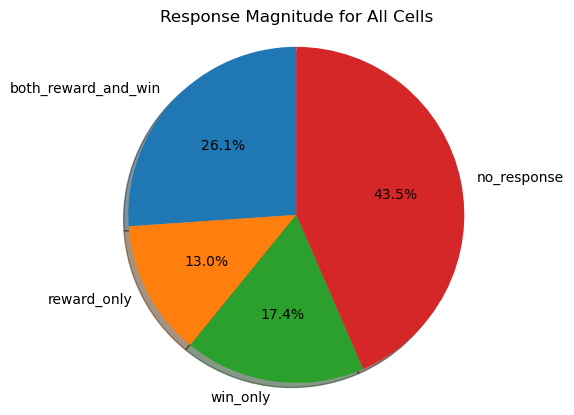

In [100]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

fig1, ax1 = plt.subplots()
ax1.pie(reward_or_win_firing_rate_difference_count.values(), labels=reward_or_win_firing_rate_difference_count.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Response Magnitude for All Cells")
plt.show()

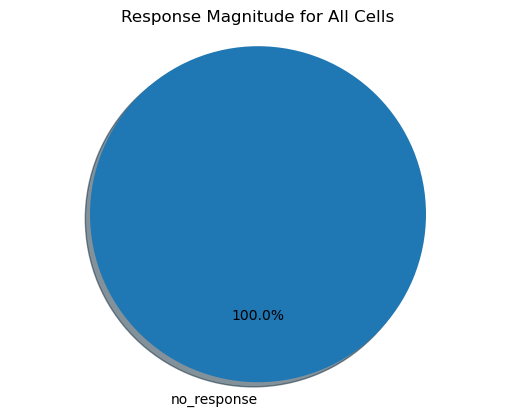

In [101]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

fig1, ax1 = plt.subplots()
ax1.pie(omission_or_loss_firing_rate_difference_count.values(), labels=omission_or_loss_firing_rate_difference_count.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Response Magnitude for All Cells")
plt.show()

# Looking at the firing rate for each 100ms time bin

## Seeing which 100ms bin each unit time belongs to

- Creating bins for each 100ms time interval

In [102]:
# Each bin's duration in seconds
bin_duration = 0.1

In [103]:
# Seeing how many bins are in the duration
# 0.1 is for 0.1 seconds or 100 miliseconds
bins_with_100ms_range = int(trial_one_way_duration / bin_duration)

In [104]:
bins_with_100ms_range

100

In [105]:
sampling_rate

20000

- Getting all the tone time bins before and after the tone

In [106]:
tone_unit_time_to_interval = {}
# Making a list of all the bins for each tone time stamp
for time in tone_time_stamps:
    tone_unit_time_to_interval[time] = [time + num * (bin_duration * sampling_rate) for num in range(bins_with_100ms_range * -1, bins_with_100ms_range)]

- The time bins for the first tone
    - Each time should be separated by an amount of the bin_duration * the sampling rate

In [107]:
tone_time_stamps[0]

1872697

In [108]:
tone_unit_time_to_interval[tone_time_stamps[0]][:5]

[1672697.0, 1674697.0, 1676697.0, 1678697.0, 1680697.0]

In [109]:
tone_unit_time_to_interval[tone_time_stamps[0]][-5:]

[2062697.0, 2064697.0, 2066697.0, 2068697.0, 2070697.0]

In [110]:
len(tone_unit_time_to_interval[tone_time_stamps[0]])

200

- Seeing which bin the tone time fits into

In [111]:
spike_column_name = "spike_time"

In [112]:
spike_tone_time_df = pd.DataFrame.from_dict(before_and_after_interval_unit_times, orient="index").reset_index().rename(columns={"index": spike_column_name})

In [113]:
spike_tone_time_df.head()

,spike_time,tone_time,before_or_after,neuron_id
0,1672940,1872697,before,113
1,1673010,1872697,before,4
2,1673176,1872697,before,61
3,1673338,1872697,before,73
4,1673406,1872697,before,25


In [114]:
all_tone_dataframes = []
for tone_time, bins_with_100ms in tone_unit_time_to_interval.items():
    # Filtering for all the rows with the current tone
    current_tone_df = spike_tone_time_df[spike_tone_time_df["tone_time"] == tone_time].copy()
    # Getting the time that each spike occured
    spike_time = current_tone_df[spike_column_name].values
    # Seeing which bin each spike fits into
    # Subtracting the number of bins so that you can get see where the spike is relative to tone time
    current_tone_df["bin_number"] = np.digitize(spike_time, tone_unit_time_to_interval[tone_time], right=True) - bins_with_100ms_range
    # Creating a list to concatenate all dataframes
    all_tone_dataframes.append(current_tone_df)

In [115]:
binned_spike_tone_time_df = pd.concat(all_tone_dataframes)

- Calculating how much time relative to the tone

In [116]:
binned_spike_tone_time_df["bin_time"] = binned_spike_tone_time_df["bin_number"] * bin_duration

In [117]:
binned_spike_tone_time_df.head()

,spike_time,tone_time,before_or_after,neuron_id,bin_number,bin_time
0,1672940,1872697,before,113,-99,-9.9
1,1673010,1872697,before,4,-99,-9.9
2,1673176,1872697,before,61,-99,-9.9
3,1673338,1872697,before,73,-99,-9.9
4,1673406,1872697,before,25,-99,-9.9


In [118]:
binned_spike_tone_time_df.tail()

,spike_time,tone_time,before_or_after,neuron_id,bin_number,bin_time
52923,66302623,66104608,after,20,100,10.0
52924,66303230,66104608,after,73,100,10.0
52925,66303521,66104608,after,61,100,10.0
52926,66303568,66104608,after,20,100,10.0
52927,66303865,66104608,after,113,100,10.0


## Calculating Firing Rate

- Getting the count of each neuron that fired during the tone interval grouped by the neuron's ID

In [119]:
binned_spike_fire_count_df = binned_spike_tone_time_df.drop(columns=["before_or_after", "bin_number"]).groupby(["tone_time", "bin_time", "neuron_id"]).count().unstack(fill_value=0).stack().reset_index().rename(columns={"spike_time": "fired_spike_count"})

In [120]:
binned_spike_fire_count_df.head()

,tone_time,bin_time,neuron_id,fired_spike_count
0,1872697,-9.9,2,0
1,1872697,-9.9,4,1
2,1872697,-9.9,18,0
3,1872697,-9.9,19,1
4,1872697,-9.9,20,0


In [121]:
binned_spike_fire_count_df.tail()

,tone_time,bin_time,neuron_id,fired_spike_count
151772,66104608,10.0,164,0
151773,66104608,10.0,172,0
151774,66104608,10.0,178,0
151775,66104608,10.0,184,0
151776,66104608,10.0,190,0


## Categorizing Rewarded vs Omitted for Training

In [122]:
binned_spike_fire_count_df["trial_type"] = binned_spike_fire_count_df["tone_time"].map(tone_timestamp_to_trial_type)

In [123]:
binned_spike_fire_count_df.head()

,tone_time,bin_time,neuron_id,fired_spike_count,trial_type
0,1872697,-9.9,2,0,win
1,1872697,-9.9,4,1,win
2,1872697,-9.9,18,0,win
3,1872697,-9.9,19,1,win
4,1872697,-9.9,20,0,win


In [124]:
binned_spike_fire_count_df.tail()

,tone_time,bin_time,neuron_id,fired_spike_count,trial_type
151772,66104608,10.0,164,0,rewarded
151773,66104608,10.0,172,0,rewarded
151774,66104608,10.0,178,0,rewarded
151775,66104608,10.0,184,0,rewarded
151776,66104608,10.0,190,0,rewarded


## Calculate average firing rate for each neuron in each bin

- We will be averaging using the bin number, because we are curious about how the firing rate changes 10 seconds before and after at each 100ms bin(averaging across sessions)
    - And we will be averaging across trials that have the same trial type

- Neurons in rows
- Mean firing rate per bin

In [125]:
averaged_firing_rate_df = binned_spike_fire_count_df.drop(columns=["tone_time"]).groupby(['neuron_id', 'bin_time', 'trial_type']).mean().reset_index()

In [126]:
averaged_firing_rate_df

,neuron_id,bin_time,trial_type,fired_spike_count
0,2,-9.9,loss,0.000000
1,2,-9.9,omission,0.000000
2,2,-9.9,rewarded,0.000000
3,2,-9.9,win,0.166667
4,2,-9.8,loss,0.000000
...,...,...,...,...
18395,190,9.9,win,0.055556
18396,190,10.0,loss,0.000000
18397,190,10.0,omission,0.000000
18398,190,10.0,rewarded,0.000000


In [127]:
pivoted_averaged_firing_rate_df = averaged_firing_rate_df.pivot_table(values='fired_spike_count', columns=['bin_time', 'trial_type'], index=["neuron_id"])

In [128]:
pivoted_averaged_firing_rate_df.head()

bin_time   -9.9                                -9.8                       \
trial_type  loss  omission  rewarded       win  loss  omission  rewarded   
neuron_id                                                                  
2            0.0  0.000000  0.000000  0.166667   0.0  0.333333  0.090909   
4            1.0  0.333333  1.272727  1.111111   0.0  0.333333  0.818182   
18           1.0  0.333333  0.363636  0.166667   0.0  0.333333  0.636364   
19           1.0  0.666667  0.000000  0.277778   1.0  0.000000  0.454545   
20           0.0  0.666667  0.727273  1.055556   0.0  0.000000  0.454545   

bin_time             -9.7             ...      9.8             9.9             \
trial_type       win  loss  omission  ...  rewarded       win  loss  omission   
neuron_id                             ...                                       
2           0.222222   0.0  0.333333  ...  0.000000  0.111111   0.0  0.000000   
4           1.166667   2.0  0.333333  ...  1.181818  1.500000   3.0  1.333333   
18          0.222222   0.0  0.000000  ...  0.181818  0.222222   1.0  0.000000   
19          0.500000   1.0  0.000000  ...  0.272727  0.444444   0.0  0.333333   
20          0.833333   0.0  0.666667  ...  1.909091  2.222222   0.0  1.333333   

bin_time                        10.0                                
trial_type  rewarded       win  loss  omission  rewarded       win  
neuron_id                                                           
2           0.181818  0.111111   0.0  0.000000  0.090909  0.222222  
4           1.727273  1.833333   3.0  1.000000  1.545455  1.500000  
18          0.272727  0.222222   0.0  0.000000  0.454545  0.166667  
19          0.272727  0.388889   0.0  0.000000  0.090909  0.055556  
20          1.818182  1.388889   0.0  1.333333  1.272727  1.666667  

[5 rows x 800 columns]

- Removing all the columns that don't have firing rate info
    - AKA the index and the tone time

In [129]:
resetted_averaged_firing_rate_array = pivoted_averaged_firing_rate_df.values

In [130]:
resetted_averaged_firing_rate_array[:5]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.09090909,
        0.22222222],
       [1.        , 0.33333333, 1.27272727, ..., 1.        , 1.54545455,
        1.5       ],
       [1.        , 0.33333333, 0.36363636, ..., 0.        , 0.45454545,
        0.16666667],
       [1.        , 0.66666667, 0.        , ..., 0.        , 0.09090909,
        0.05555556],
       [0.        , 0.66666667, 0.72727273, ..., 1.33333333, 1.27272727,
        1.66666667]])

# PCA with Neuron Rows

## Standarizing the Data

In [131]:
from sklearn.preprocessing import StandardScaler

In [132]:
# Separating out the features
x = resetted_averaged_firing_rate_array#.loc[:].values# Separating out the target
resetted_averaged_firing_rate_array = StandardScaler().fit_transform(x)

## Calculating the PCA

In [133]:
from sklearn.decomposition import PCA


- Getting the PC Coeffecients

In [134]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(resetted_averaged_firing_rate_array)
principal_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [135]:
principal_df.head()

,principal component 1,principal component 2
0,-12.296258,0.045446
1,57.491731,-14.998821
2,-6.050665,-1.410203
3,-4.825128,3.767855
4,44.316213,-22.851565


In [136]:
principal_df["principal component 1"]

0    -12.296258
1     57.491731
2     -6.050665
3     -4.825128
4     44.316213
5     63.988974
6    -15.655892
7     -8.474935
8     -7.515456
9    -13.152038
10   -13.951722
11    -0.772796
12     3.936284
13     8.121280
14     2.937698
15    -1.092997
16    -6.587701
17   -15.198805
18   -14.870186
19   -14.613589
20   -14.468781
21   -14.970247
22   -16.294986
Name: principal component 1, dtype: float64

In [137]:
pc1_product = pivoted_averaged_firing_rate_df.reset_index(drop=True).multiply(principal_df["principal component 1"], axis="index")

In [138]:
pc1_product

bin_time        -9.9                                         -9.8   \
trial_type       loss   omission    rewarded        win       loss   
0           -0.000000  -0.000000   -0.000000  -2.049376  -0.000000   
1           57.491731  19.163910   73.171294  63.879701   0.000000   
2           -6.050665  -2.016888   -2.200242  -1.008444  -0.000000   
3           -4.825128  -3.216752   -0.000000  -1.340313  -4.825128   
4            0.000000  29.544142   32.229973  46.778225   0.000000   
5           63.988974  21.329658  180.332562  81.763689   0.000000   
6           -0.000000  -0.000000   -1.423263  -0.000000  -0.000000   
7           -0.000000  -0.000000   -1.540897  -1.412489  -0.000000   
8           -0.000000  -5.010304   -0.000000  -2.087627  -0.000000   
9           -0.000000  -0.000000   -2.391280  -3.653344  -0.000000   
10          -0.000000  -0.000000   -0.000000  -0.775096  -0.000000   
11          -0.000000  -0.257599   -0.070254  -0.343465  -0.000000   
12           3.936284   2.624189    0.715688   2.405507   0.000000   
13           0.000000   5.414187    4.429789   3.609458  16.242560   
14           0.000000   0.000000    0.801190   1.632055   2.937698   
15          -0.000000  -1.457329   -0.397453  -0.607220  -1.092997   
16          -0.000000  -2.195900   -1.197764  -1.829917  -0.000000   
17          -0.000000 -10.132536   -2.763419  -0.000000  -0.000000   
18          -0.000000  -0.000000   -1.351835  -0.826121  -0.000000   
19          -0.000000  -0.000000   -1.328508  -1.623732 -14.613589   
20          -0.000000  -0.000000   -2.630687  -0.000000  -0.000000   
21          -0.000000  -0.000000   -0.000000  -2.495041  -0.000000   
22          -0.000000  -5.431662   -0.000000  -0.000000  -0.000000   

bin_time                                             -9.7              ...  \
trial_type    omission    rewarded         win        loss   omission  ...   
0            -4.098753   -1.117842   -2.732502   -0.000000  -4.098753  ...   
1            19.163910   47.038689   67.073687  114.983463  19.163910  ...   
2            -2.016888   -3.850423   -1.344592   -0.000000  -0.000000  ...   
3            -0.000000   -2.193240   -2.412564   -4.825128  -0.000000  ...   
4             0.000000   20.143733   36.930178    0.000000  29.544142  ...   
5           106.648290  139.612306  138.642776  127.977947  63.988974  ...   
6            -0.000000   -0.000000   -1.739544   -0.000000  -5.218631  ...   
7            -0.000000   -3.081794   -1.412489   -0.000000  -0.000000  ...   
8            -7.515456   -0.683223   -0.835051   -0.000000 -12.525761  ...   
9            -0.000000   -0.000000   -0.000000   -0.000000  -0.000000  ...   
10           -0.000000   -0.000000   -1.550191   -0.000000  -4.650574  ...   
11           -0.257599   -0.281017   -0.171732   -0.000000  -0.000000  ...   
12            1.312095    1.789220    2.405507    0.000000   2.624189  ...   
13            8.121280    3.691491    4.511822    0.000000   0.000000  ...   
14            0.000000    0.801190    0.652822    0.000000   0.000000  ...   
15           -0.364332   -0.298090   -0.546498   -0.000000  -0.364332  ...   
16           -0.000000   -2.395527   -1.097950   -0.000000  -0.000000  ...   
17          -10.132536   -1.381710   -1.688756   -0.000000  -0.000000  ...   
18           -0.000000   -4.055505   -0.000000   -0.000000  -4.956729  ...   
19           -0.000000   -1.328508   -0.000000   -0.000000  -0.000000  ...   
20           -0.000000   -0.000000   -0.000000   -0.000000  -4.822927  ...   
21           -0.000000   -5.443726   -0.831680   -0.000000  -0.000000  ...   
22           -0.000000   -0.000000   -0.000000   -0.000000  -0.000000  ...   

bin_time          9.8                    9.9                         \
trial_type    rewarded        win        loss   omission   rewarded   
0            -0.000000  -1.366251   -0.000000  -0.000000  -2.235683   
1            67.944773  86.237597  172.475194  76.655642  99.303900   
2            -

In [139]:
pc1_product.mean()

bin_time  trial_type
-9.9      loss           4.980052
          omission       2.102483
          rewarded      11.929778
          win            7.826802
-9.8      loss          -0.058759
                          ...    
 9.9      win           10.227655
 10.0     loss          10.165772
          omission       7.713838
          rewarded       8.420376
          win            8.527327
Length: 800, dtype: float64

In [140]:
pc2_product = pivoted_averaged_firing_rate_df.reset_index(drop=True).multiply(principal_df["principal component 2"], axis="index")

In [141]:
pc2_product

bin_time        -9.9                                       -9.8              \
trial_type       loss   omission   rewarded        win      loss   omission   
0            0.000000   0.000000   0.000000   0.007574  0.000000   0.015149   
1          -14.998821  -4.999607 -19.089408 -16.665356 -0.000000  -4.999607   
2           -1.410203  -0.470068  -0.512801  -0.235034 -0.000000  -0.470068   
3            3.767855   2.511903   0.000000   1.046626  3.767855   0.000000   
4           -0.000000 -15.234377 -16.619320 -24.121097 -0.000000  -0.000000   
5           30.867336  10.289112  86.989764  39.441596  0.000000  51.445560   
6           -0.000000  -0.000000  -0.021967  -0.000000 -0.000000  -0.000000   
7            0.000000   0.000000   0.863815   0.791831  0.000000   0.000000   
8            0.000000   2.123939   0.000000   0.884974  0.000000   3.185908   
9            0.000000   0.000000   0.063179   0.096524  0.000000   0.000000   
10          -0.000000  -0.000000  -0.000000  -0.010173 -0.000000  -0.000000   
11          -0.000000  -1.031361  -0.281280  -1.375148 -0.000000  -1.031361   
12          -0.940506  -0.627004  -0.171001  -0.574754 -0.000000  -0.313502   
13          -0.000000  -0.803910  -0.657744  -0.535940 -2.411730  -1.205865   
14          -0.000000  -0.000000  -0.452590  -0.921943 -1.659497  -0.000000   
15           0.000000   1.620730   0.442017   0.675304  1.215548   0.405183   
16           0.000000   1.034103   0.564056   0.861753  0.000000   0.000000   
17           0.000000   0.075395   0.020562   0.000000  0.000000   0.075395   
18          -0.000000  -0.000000  -0.009989  -0.006105 -0.000000  -0.000000   
19          -0.000000  -0.000000  -0.017433  -0.021307 -0.191761  -0.000000   
20          -0.000000  -0.000000  -0.109602  -0.000000 -0.000000  -0.000000   
21           0.000000   0.000000   0.000000   0.039546  0.000000   0.000000   
22          -0.000000  -0.047832  -0.000000  -0.000000 -0.000000  -0.000000   

bin_time                              -9.7              ...       9.8   \
trial_type   rewarded        win       loss   omission  ...   rewarded   
0            0.004131   0.010099   0.000000   0.015149  ...   0.000000   
1          -12.271762 -17.498624 -29.997641  -4.999607  ... -17.725879   
2           -0.897402  -0.313379  -0.000000  -0.000000  ...  -0.256401   
3            1.712661   1.883927   3.767855   0.000000  ...   1.027597   
4          -10.387075 -19.042971  -0.000000 -15.234377  ... -43.625716   
5           67.346914  66.879227  61.734672  30.867336  ...  58.928550   
6           -0.000000  -0.026848  -0.000000  -0.080545  ...  -0.043934   
7            1.727631   0.791831   0.000000   0.000000  ...   0.000000   
8            0.289628   0.353990   0.000000   5.309846  ...   0.000000   
9            0.000000   0.000000   0.000000   0.000000  ...   0.031590   
10          -0.000000  -0.020346  -0.000000  -0.061038  ...  -0.016647   
11          -1.125121  -0.687574  -0.000000  -0.000000  ...  -1.406401   
12          -0.427503  -0.574754  -0.000000  -0.627004  ...  -0.342002   
13          -0.548120  -0.669925  -0.000000  -0.000000  ...  -0.767369   
14          -0.452590  -0.368777  -0.000000  -0.000000  ...  -1.206907   
15           0.331513   0.607774   0.000000   0.405183  ...   0.442017   
16           1.128113   0.517052   0.000000   0.000000  ...   0.282028   
17           0.010281   0.012566   0.000000   0.000000  ...   0.010281   
18          -0.029968  -0.000000  -0.000000  -0.036628  ...  -0.000000   
19          -0.017433  -0.000000  -0.000000  -0.000000  ...  -0.034866   
20          -0.000000  -0.000000  -0.000000  -0.200937  ...  -0.000000   
21           0.086282   0.013182   0.000000   0.000000  ...   0.021571   
22          -0.000000  -0.000000  -0.000000  -0.000000  ...  -0.000000   

bin_time                    9.9                                         10.0  \
trial_type        win       loss   omission   rewarded        win       loss   
0            

In [142]:
pc2_product.mean()

bin_time  trial_type
-9.9      loss          0.751550
          omission     -0.241695
          rewarded      2.217403
          win          -0.027006
-9.8      loss          0.031322
                          ...   
 9.9      win          -0.886061
 10.0     loss         -0.520318
          omission     -0.781082
          rewarded     -1.221261
          win          -1.536320
Length: 800, dtype: float64

In [143]:
pc_product = pd.concat([pc1_product.mean(), pc2_product.mean()], axis=1)#.reset_index()

In [144]:
pc_product.head()

0         1
bin_time trial_type                     
-9.9     loss         4.980052  0.751550
         omission     2.102483 -0.241695
         rewarded    11.929778  2.217403
         win          7.826802 -0.027006
-9.8     loss        -0.058759  0.031322

In [145]:
pc_product = pc_product.reset_index()

In [146]:
pc_product.head()

,bin_time,trial_type,0,1
0,-9.9,loss,4.980052,0.751550
1,-9.9,omission,2.102483,-0.241695
2,-9.9,rewarded,11.929778,2.217403
3,-9.9,win,7.826802,-0.027006
4,-9.8,loss,-0.058759,0.031322


In [147]:
def get_before_during_after(x):
    if -10 <= x < -5:
        return "-10s to 5s"
    elif -5 <= x < 0:
        return "-5s to 0s"
    elif 0 <= x < 5:
        return "0s to 5s"
    elif 5 <= x <= 10:
        return "5s to 10s"
    else:
        return np.nan

In [148]:
pc_product["before_during_after"] = pc_product["bin_time"].apply(lambda x: get_before_during_after(x))

In [149]:
pc_product.head()

,bin_time,trial_type,0,1,before_during_after
0,-9.9,loss,4.980052,0.751550,-10s to 5s
1,-9.9,omission,2.102483,-0.241695,-10s to 5s
2,-9.9,rewarded,11.929778,2.217403,-10s to 5s
3,-9.9,win,7.826802,-0.027006,-10s to 5s
4,-9.8,loss,-0.058759,0.031322,-10s to 5s


In [150]:
pc_product["outcome_and_when"] = pc_product.apply(lambda x: x["before_during_after"] + " " + x["trial_type"], axis=1)

In [151]:
pc_product.head()

,bin_time,trial_type,0,1,before_during_after,outcome_and_when
0,-9.9,loss,4.980052,0.751550,-10s to 5s,-10s to 5s loss
1,-9.9,omission,2.102483,-0.241695,-10s to 5s,-10s to 5s omission
2,-9.9,rewarded,11.929778,2.217403,-10s to 5s,-10s to 5s rewarded
3,-9.9,win,7.826802,-0.027006,-10s to 5s,-10s to 5s win
4,-9.8,loss,-0.058759,0.031322,-10s to 5s,-10s to 5s loss


- Getting only rows from -5 to 5 seconds

In [152]:
pc_product = pc_product[pc_product["bin_time"] >= -5]

In [153]:
omission_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "omission" in name]
rewarded_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "rewarded" in name]
win_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "win" in name]
loss_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "loss" in name]


In [154]:
pc_product

,bin_time,trial_type,0,1,before_during_after,outcome_and_when
196,-5.0,loss,9.130355,1.198916,-5s to 0s,-5s to 0s loss
197,-5.0,omission,8.832951,2.824670,-5s to 0s,-5s to 0s omission
198,-5.0,rewarded,6.411202,1.240545,-5s to 0s,-5s to 0s rewarded
199,-5.0,win,6.959960,0.522294,-5s to 0s,-5s to 0s win
200,-4.9,loss,9.464546,-1.519391,-5s to 0s,-5s to 0s loss
...,...,...,...,...,...,...
795,9.9,win,10.227655,-0.886061,5s to 10s,5s to 10s win
796,10.0,loss,10.165772,-0.520318,5s to 10s,5s to 10s loss
797,10.0,omission,7.713838,-0.781082,5s to 10s,5s to 10s omission
798,10.0,rewarded,8.420376,-1.221261,5s to 10s,5s to 10s rewarded


In [155]:
omission_pc = pc_product[pc_product["trial_type"] == "omission"]

In [156]:
omission_pc

,bin_time,trial_type,0,1,before_during_after,outcome_and_when
197,-5.0,omission,8.832951,2.824670,-5s to 0s,-5s to 0s omission
201,-4.9,omission,8.010662,2.260824,-5s to 0s,-5s to 0s omission
205,-4.8,omission,7.897473,1.733126,-5s to 0s,-5s to 0s omission
209,-4.7,omission,10.183418,1.484554,-5s to 0s,-5s to 0s omission
213,-4.6,omission,8.970675,0.868378,-5s to 0s,-5s to 0s omission
...,...,...,...,...,...,...
781,9.6,omission,6.599392,-0.411127,5s to 10s,5s to 10s omission
785,9.7,omission,9.595364,-2.031439,5s to 10s,5s to 10s omission
789,9.8,omission,6.201464,-0.953659,5s to 10s,5s to 10s omission
793,9.9,omission,9.587334,-0.408680,5s to 10s,5s to 10s omission


In [157]:
averaged_omission_pc = omission_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()

/tmp/ipykernel_3247196/866166829.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged_omission_pc = omission_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()


In [158]:
averaged_omission_pc

,index,bin_time,0,1
0,0,-4.9,8.247029,2.272873
1,1,-4.6,9.479368,1.258927
2,2,-4.3,8.223733,0.533337
3,3,-4.0,10.726160,0.612238
4,4,-3.7,7.899515,-0.192528
5,5,-3.4,8.117424,0.794562
6,6,-3.1,9.406654,-0.136624
7,7,-2.8,8.583187,-0.183485
8,8,-2.5,6.980497,-0.117231
9,9,-2.2,9.669849,0.787775


In [159]:
rewarded_pc = pc_product[pc_product["trial_type"] == "rewarded"]

In [160]:
averaged_rewarded_pc = rewarded_pc.groupby(np.arange(len(rewarded_pc))//3).mean().reset_index()

/tmp/ipykernel_3247196/1512505606.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged_rewarded_pc = rewarded_pc.groupby(np.arange(len(rewarded_pc))//3).mean().reset_index()


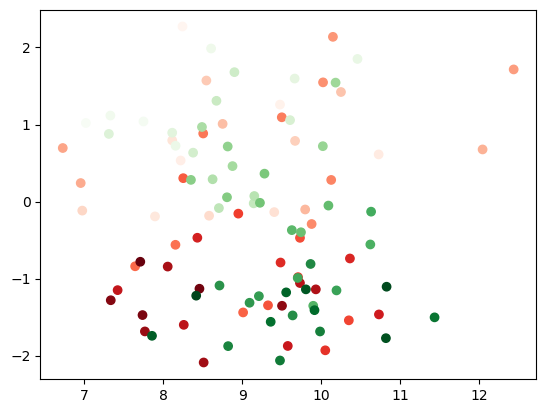

In [161]:
plt.scatter(averaged_omission_pc[0], averaged_omission_pc[1], c=averaged_omission_pc["index"], cmap='Reds')
plt.scatter(averaged_rewarded_pc[0], averaged_rewarded_pc[1], c=averaged_rewarded_pc["index"], cmap='Greens')

plt.show()

In [162]:
all_categories = sorted(pc_product["outcome_and_when"].unique())

In [163]:
all_categories = [category for category in all_categories if not "-10" in category]

In [164]:
all_categories

['-5s to 0s loss',
 '-5s to 0s omission',
 '-5s to 0s rewarded',
 '-5s to 0s win',
 '0s to 5s loss',
 '0s to 5s omission',
 '0s to 5s rewarded',
 '0s to 5s win',
 '5s to 10s loss',
 '5s to 10s omission',
 '5s to 10s rewarded',
 '5s to 10s win']

win: blue
loss: yellow
rewarded: green
omission: red

In [165]:
all_colors = ["gold", "pink", "lightgreen", "lightblue", "orange", "red", "green", "cyan", "darkorange", "darkred", "darkgreen", "darkcyan"]


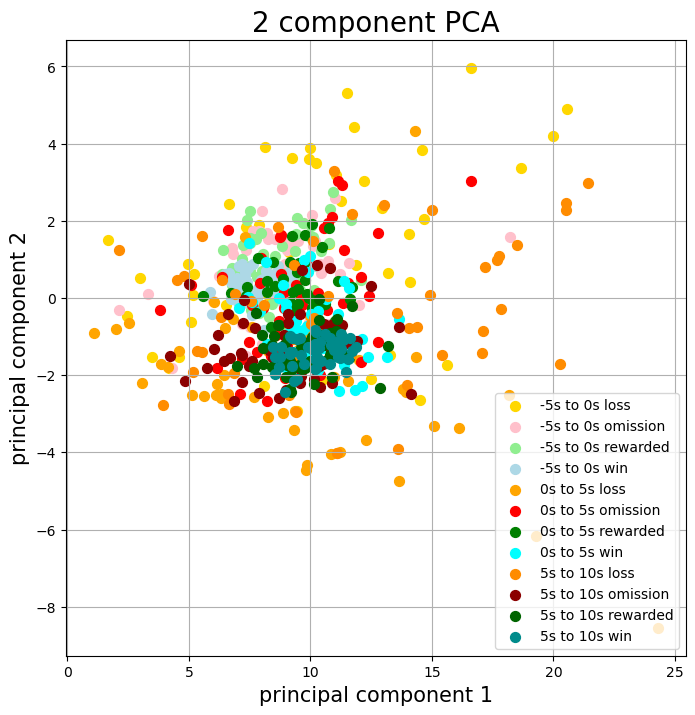

In [166]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = rewarded_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(all_categories, all_colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(all_categories)
ax.grid()

## Looking at each plot individually across time

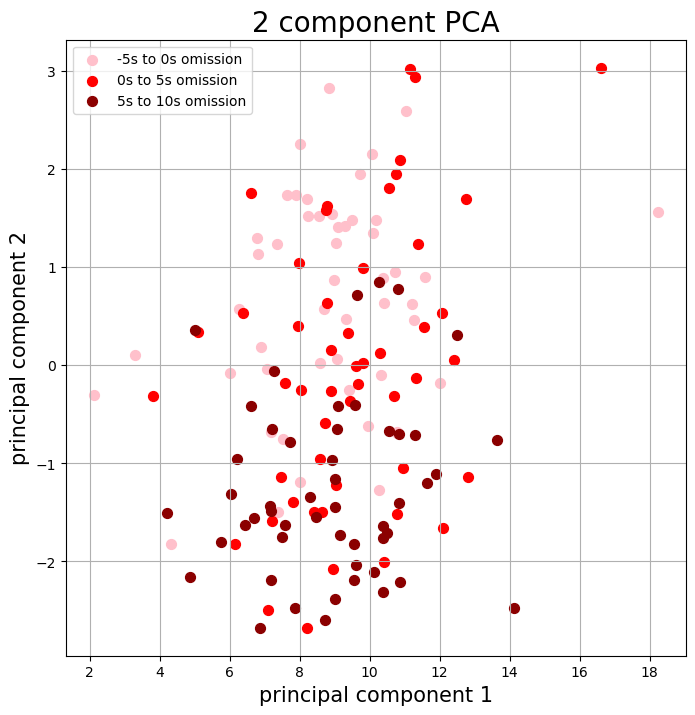

In [167]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["pink", "red", "darkred"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

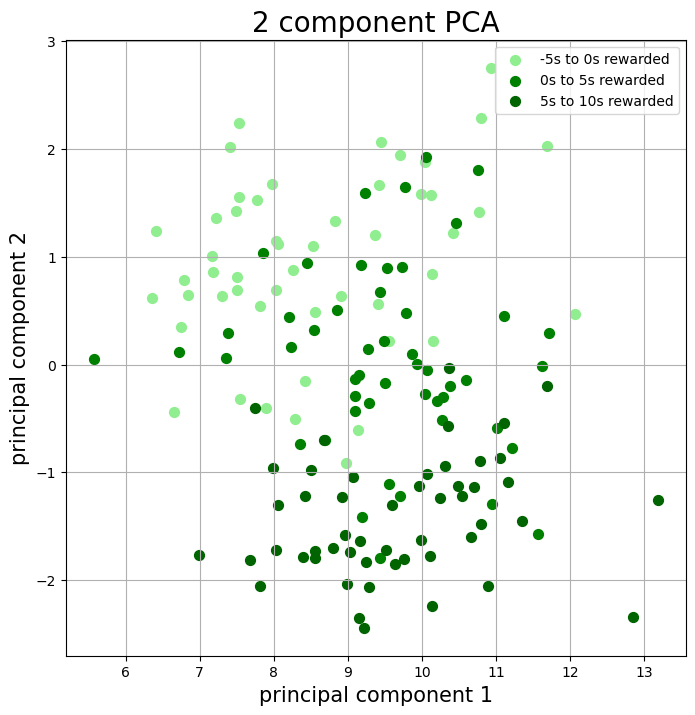

In [168]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = rewarded_categories
colors = ["lightgreen", "green", "darkgreen"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

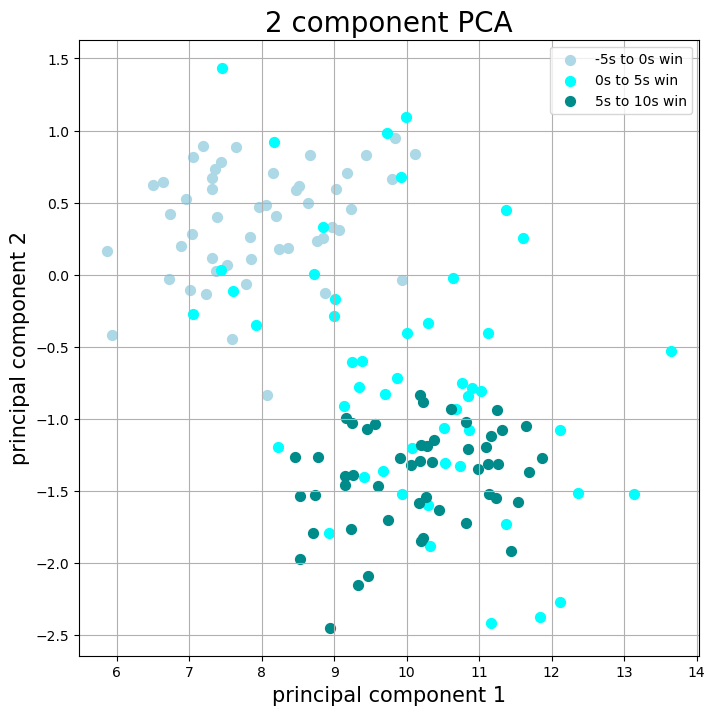

In [169]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = win_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

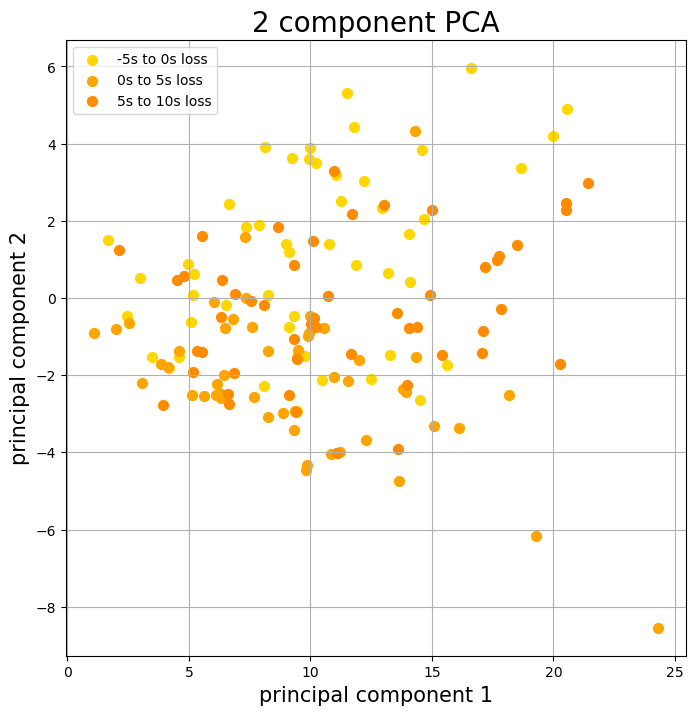

In [170]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = loss_categories
colors = ["gold", "orange", "darkorange"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

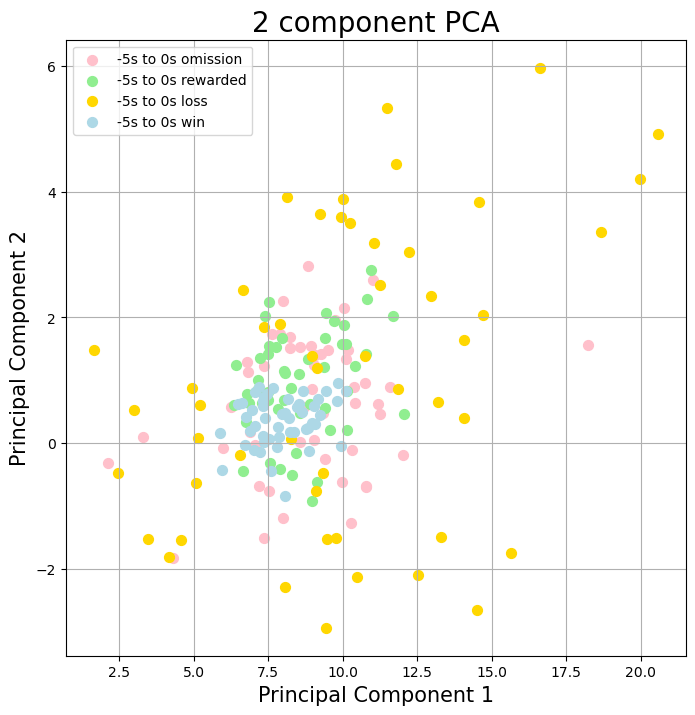

In [171]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['-5s to 0s omission', '-5s to 0s rewarded', '-5s to 0s loss', '-5s to 0s win']
colors = ["pink", "lightgreen", "gold", "lightblue"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

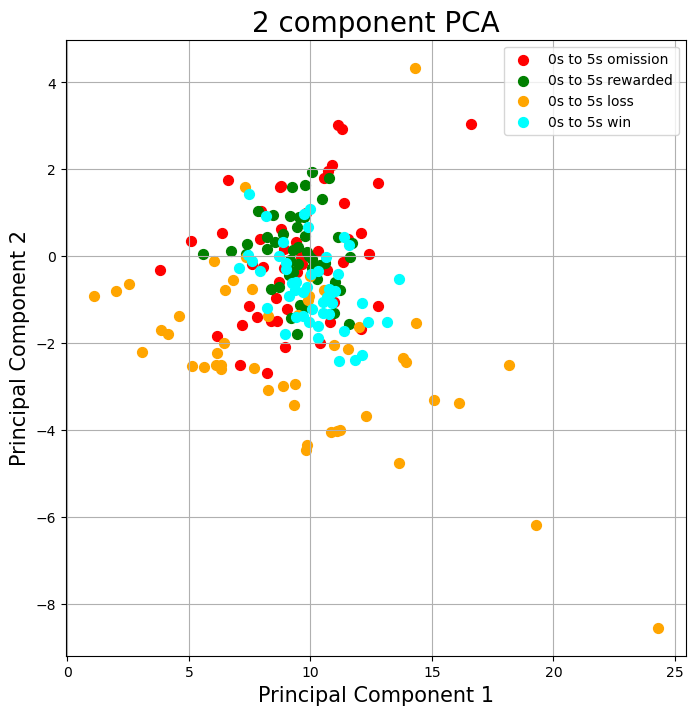

In [172]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0s to 5s omission', '0s to 5s rewarded', '0s to 5s loss', '0s to 5s win']
colors = ["red", "green", "orange", "cyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

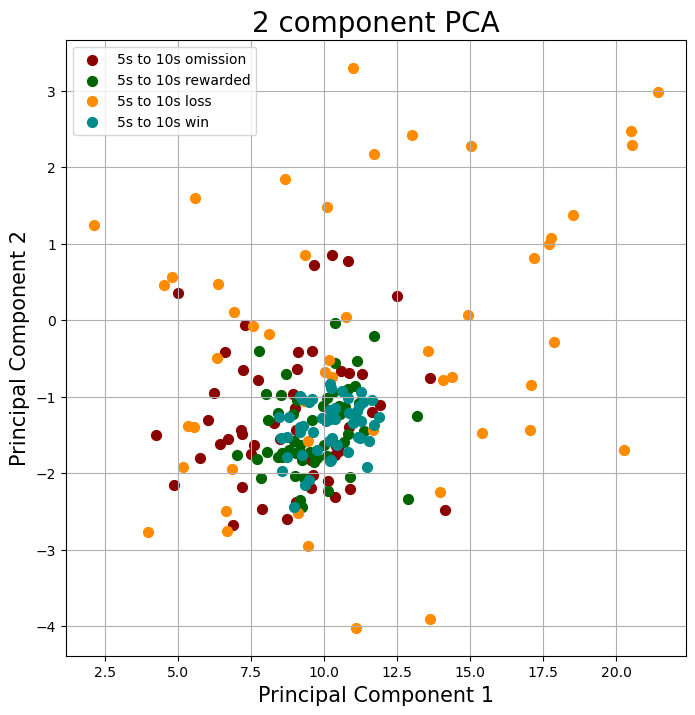

In [173]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['5s to 10s omission', '5s to 10s rewarded', '5s to 10s loss', '5s to 10s win']
colors = ["darkred", "darkgreen", "darkorange", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()